# Set up

In [2]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [3]:
import warnings
# warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import patsy
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [5]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [6]:
element_gameweek_df = pd.read_csv(file_name)

In [7]:
current_event = 20

In [8]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [9]:
element_gameweek_df.fillna(3, inplace=True)

In [10]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,3.0,3.0,3.0,3.0,3.0,3,3.000000,3.000000,3.000000,3.0
1,cech,1,2,14,1,6,0,1,50,0,...,3.0,3.0,3.0,3.0,3.0,3,0.681818,3.000000,3.000000,3.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,3.0,3.0,3.0,3,3.750000,0.000000,3.000000,3.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,3.0,6.0,3.0,1,4.493304,0.000000,4.901786,3.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [11]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [12]:
last_train_event = 15

In [13]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [14]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [15]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [16]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [17]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [18]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [19]:
n_features = X.shape[1]

## Selecting features

In [26]:
estimator = GradientBoostingRegressor(n_estimators=120,
                                      max_features=0.7,
                                      min_samples_leaf=0.015,
                                      learning_rate=0.03,
                                      criterion='mse',
                                      random_state=0)
selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
F

Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
F

Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                                          learning_rate=0.03, loss='ls',
                                          max_depth=3, max_features=0.7,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=0.015,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=120,
                                          n_iter_no_change=None, presort='auto',
                                          random_state=0, subsample=1.0,
                                          tol=0.0001, validation_fraction=0.1,
              

In [30]:
features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
selected_features = pd.Series(features)[selector.support_]
list(selected_features)

['value',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_minutes_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_total_points_own_team',
 'rolling_avg_total_points_opposition_team',
 'rolling_avg_total_points_against_opposition_team',
 'rolling_avg_total_points_against_opposition_team_element_type',
 'expected_avg_total_points_against_opposition_team',
 'expected_avg_total_points_at_ground']

In [31]:
stark_X_sel = X[:,selector.support_]
stark_X_train_sel = X_train[:,selector.support_]
stark_X_test_sel = X_test[:,selector.support_]

In [32]:
lush_X_sel = X
lush_X_train_sel = X_train
lush_X_test_sel = X_test

## Tuning model

### GP tuner

#### Gradient boosted trees (lush)

In [43]:
lush_space = [
    Integer(100, 200, name='n_estimators'),
    Real(0.7, 1.0, 'uniform', name='max_features'),
    Real(0.015, 0.05, 'log-uniform', name='min_samples_leaf'),
    Real(0.01, 0.05, 'log-uniform', name='learning_rate'),
]

In [44]:
lush_gp_model = GradientBoostingRegressor(criterion='mse')

@use_named_args(lush_space)
def lush_objective(**params):
    lush_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lush_gp_model,
            lush_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [45]:
lush_res_gp_arr = []
for i in range(1, 11):
    print('minimisation iteration', i)
    lush_res_gp = gp_minimize(lush_objective, lush_space, n_calls=20, verbose=2)
    lush_res_gp_arr.append(lush_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.4157
Function value obtained: 9.4391
Current minimum: 9.4391
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.8237
Function value obtained: 9.4123
Current minimum: 9.4123
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.6515
Function value obtained: 9.4103
Current minimum: 9.4103
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.8048
Function value obtained: 9.4758
Current minimum: 9.4103
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.8116
Function value obtained: 9.4801
Current minimum: 9.4103
Iteration 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6903
Function value obtained: 9.4145
Current minimum: 9.4145
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.4565
Function value obtained: 9.4384
Current minimum: 9.4145
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.5397
Function value obtained: 9.5042
Current minimum: 9.4145
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.7531
Function value obtained: 9.4623
Current minimum: 9.4145
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.5612
Function value obtained: 9.4438
Current minimum: 9.4145
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation d

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.6199
Function value obtained: 9.4343
Current minimum: 9.4343
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.4864
Function value obtained: 9.4719
Current minimum: 9.4343
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.9088
Function value obtained: 9.5299
Current minimum: 9.4343
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.8662
Function value obtained: 9.4329
Current minimum: 9.4329
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.2717
Function value obtained: 9.4325
Current minimum: 9.4325
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation d

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.2182
Function value obtained: 9.4718
Current minimum: 9.4048
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.3527
Function value obtained: 9.4337
Current minimum: 9.4048
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 4.3089
Function value obtained: 9.4465
Current minimum: 9.4048
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.2396
Function value obtained: 9.5182
Current minimum: 9.4048
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 3.4650
Function value obtained: 9.4416
Current minimum: 9.4048
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation d

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.5819
Function value obtained: 9.4338
Current minimum: 9.4259
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.5889
Function value obtained: 9.4810
Current minimum: 9.4259
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.1989
Function value obtained: 9.4299
Current minimum: 9.4259
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.2662
Function value obtained: 9.4467
Current minimum: 9.4259
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 3.4735
Function value obtained: 9.5284
Current minimum: 9.4259
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation

In [46]:
for i in lush_res_gp_arr:
    print(i.fun)
print('\n')
for i in lush_res_gp_arr:
    print(i.x)

9.409790020128217
9.39840699620296
9.407125805359364
9.40855432288784
9.414008426564367
9.397962808535643
9.404808803366791
9.404268485223039
9.412102244256815
9.402684590961513


[144, 0.8884340197772544, 0.0228914307063885, 0.023127903106768467]
[140, 0.7874798404823927, 0.032035208520513433, 0.030076893721094667]
[167, 0.7280240515739198, 0.049999999999999996, 0.017743767603234706]
[156, 0.7, 0.049999999999999996, 0.019738261517926018]
[123, 0.7, 0.049999999999999996, 0.02253902041491651]
[106, 1.0, 0.03240707558741339, 0.027373518355931915]
[142, 0.9810002915291318, 0.029297692254250534, 0.029916209622774713]
[200, 0.7, 0.015, 0.017573420391462504]
[100, 1.0, 0.02482975449085369, 0.049999999999999996]
[108, 0.7654662140434022, 0.037001077838458934, 0.0369652245634571]


#### Gradient boosted trees (stark)

In [93]:
stark_space = [
    Integer(100, 200, name='n_estimators'),
    Real(0.8, 1.0, 'uniform', name='max_features'),
    Real(0.02, 0.03, 'uniform', name='min_samples_leaf'),
    Real(0.01, 0.05, 'uniform', name='learning_rate'),
]

In [94]:
stark_gp_model = GradientBoostingRegressor(criterion='mse')

@use_named_args(stark_space)
def stark_objective(**params):
    stark_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            stark_gp_model,
            stark_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [95]:
stark_res_gp_arr = []
for i in range(1, 11):
    print('minimisation iteration', i)
    stark_res_gp = gp_minimize(stark_objective, stark_space, n_calls=20, verbose=2)
    stark_res_gp_arr.append(stark_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3362
Function value obtained: 9.4461
Current minimum: 9.4461
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3334
Function value obtained: 9.4057
Current minimum: 9.4057
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3087
Function value obtained: 9.3994
Current minimum: 9.3994
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4008
Function value obtained: 9.3929
Current minimum: 9.3929
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3156
Function value obtained: 9.3779
Current minimum: 9.3779
Iteration 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3019
Function value obtained: 9.4720
Current minimum: 9.4233
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3402
Function value obtained: 9.4128
Current minimum: 9.4128
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3557
Function value obtained: 9.4154
Current minimum: 9.4128
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3826
Function value obtained: 9.4107
Current minimum: 9.4107
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3837
Function value obtained: 9.3889
Current minimum: 9.3889
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation d

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3589
Function value obtained: 9.4178
Current minimum: 9.4079
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2892
Function value obtained: 9.4240
Current minimum: 9.4079
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2683
Function value obtained: 9.4148
Current minimum: 9.4079
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3857
Function value obtained: 9.4553
Current minimum: 9.4079
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.3149
Function value obtained: 9.4064
Current minimum: 9.4064
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation d

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2705
Function value obtained: 9.3761
Current minimum: 9.3761
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2563
Function value obtained: 9.4850
Current minimum: 9.3761
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.2351
Function value obtained: 9.3779
Current minimum: 9.3761
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.2527
Function value obtained: 9.3953
Current minimum: 9.3761
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3681
Function value obtained: 9.4253
Current minimum: 9.3761
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation d

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3066
Function value obtained: 9.3843
Current minimum: 9.3843
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.2426
Function value obtained: 9.4231
Current minimum: 9.3843
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.3641
Function value obtained: 9.3874
Current minimum: 9.3843
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.4167
Function value obtained: 9.3934
Current minimum: 9.3843
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3204
Function value obtained: 9.4246
Current minimum: 9.3843
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation

In [96]:
for i in stark_res_gp_arr:
    print(i.fun)
print('\n')
for i in stark_res_gp_arr:
    print(i.x)

9.372244607185428
9.386102310200572
9.374180444586242
9.340454446924378
9.381962799138723
9.359230228844707
9.36655641143457
9.374180444586242
9.374180444586242
9.377365520441167


[170, 0.8040844007898146, 0.021186053335523643, 0.031085164202558878]
[165, 0.807951558210909, 0.02171483185043576, 0.023234733832004188]
[200, 1.0, 0.03, 0.01]
[115, 0.8509123356201592, 0.021082482245849854, 0.0415877309364023]
[100, 1.0, 0.02, 0.05]
[147, 0.8789599004375964, 0.021636049561390182, 0.03480061528944965]
[100, 1.0, 0.03, 0.022498217062229934]
[200, 1.0, 0.03, 0.01]
[200, 1.0, 0.03, 0.01]
[154, 1.0, 0.03, 0.014358316895597828]


### Grid search

#### Gradient boosted trees (lush)

In [52]:
max_features_lush = [0.61, 0.62, 0.63]
min_samples_leaf_lush = [0.0125, 0.015, 0.0175]
learning_rate_lush = [0.0325, 0.035, 0.0375]


parameters_lush = {
    'max_features': max_features_lush,
    'min_samples_leaf': min_samples_leaf_lush,
    'learning_rate': learning_rate_lush
}

In [77]:
gs_model_lush = GridSearchCV(
    GradientBoostingRegressor(n_estimators=120,
                              criterion='mse',
                              random_state=0),
    parameters_lush,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_lush.fit(lush_X_sel, y.ravel())

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] learning_rate=0.0325, max_features=0.61, min_samples_leaf=0.0125 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0325, max_features=0.61, min_samples_leaf=0.0125, total=   2.2s
[CV] learning_rate=0.0325, max_features=0.61, min_samples_leaf=0.015 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  learning_rate=0.0325, max_features=0.61, min_samples_leaf=0.015, total=   2.0s
[CV] learning_rate=0.0325, max_features=0.61, min_samples_leaf=0.0175 
[CV]  learning_rate=0.0325, max_features=0.61, min_samples_leaf=0.0175, total=   1.9s
[CV] learning_rate=0.0325, max_features=0.62, min_samples_leaf=0.0125 
[CV]  learning_rate=0.0325, max_features=0.62, min_samples_leaf=0.0125, total=   2.0s
[CV] learning_rate=0.0325, max_features=0.62, min_samples_leaf=0.015 .
[CV]  learning_rate=0.0325, max_features=0.62, min_samples_leaf=0.015, total=   2.0s
[CV] learning_rate=0.0325, max_features=0.62, min_samples_leaf=0.0175 
[CV]  learning_rate=0.0325, max_features=0.62, min_samples_leaf=0.0175, total=   2.0s
[CV] learning_rate=0.0325, max_features=0.63, min_samples_leaf=0.0125 
[CV]  learning_rate=0.0325, max_features=0.63, min_samples_leaf=0.0125, total=   2.0s
[CV] learning_rate=0.0325, max_features=0.63, min_samples_leaf=0.015 .
[CV]  learning_rate=0.0325, max_features=0.63, min_samples_l

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   53.9s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=GradientBoostingRegressor(alpha=0.9, criterion='mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,...
                                                 subsample=1.0, tol=0.0001,
                                                 validation_fraction=0.1,
         

In [78]:
gs_model_df_lush = pd.DataFrame(gs_model_lush.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_learning_rate',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df_lush

,param_max_features,param_min_samples_leaf,param_learning_rate,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.61,0.0125,0.0325,-2.184947,-9.489880
1,0.61,0.015,0.0325,-2.175146,-9.424146
2,0.61,0.0175,0.0325,-2.179548,-9.421573
3,0.62,0.0125,0.0325,-2.184511,-9.471069
4,0.62,0.015,0.0325,-2.174025,-9.441835
5,0.62,0.0175,0.0325,-2.178600,-9.451566
6,0.63,0.0125,0.0325,-2.188981,-9.481235
7,0.63,0.015,0.0325,-2.182449,-9.467833
8,0.63,0.0175,0.0325,-2.179427,-9.440174
9,0.61,0.0125,0.035,-2.189605,-9.483921


In [79]:
gs_model_df_lush[
    gs_model_df_lush['split0_test_neg_mean_squared_error'] == \
    gs_model_df_lush['split0_test_neg_mean_squared_error'].max()]

,param_max_features,param_min_samples_leaf,param_learning_rate,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
10,0.61,0.015,0.035,-2.178648,-9.419429


#### Gradient boosted trees (stark)

In [113]:
max_features_stark = [0.79, 0.8, 0.81]
min_samples_leaf_stark = [0.019, 0.02, 0.021]
learning_rate_stark = [0.049, 0.05, 0.051]


parameters_stark = {
    'max_features': max_features_stark,
    'min_samples_leaf': min_samples_leaf_stark,
    'learning_rate': learning_rate_stark
}

In [114]:
gs_model_stark = GridSearchCV(
    GradientBoostingRegressor(n_estimators=120,
                              criterion='mse',
                              random_state=0),
    parameters_stark,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_stark.fit(stark_X_sel, y.ravel())

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] learning_rate=0.049, max_features=0.79, min_samples_leaf=0.019 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.049, max_features=0.79, min_samples_leaf=0.019, total=   0.3s
[CV] learning_rate=0.049, max_features=0.79, min_samples_leaf=0.02 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.049, max_features=0.79, min_samples_leaf=0.02, total=   0.3s
[CV] learning_rate=0.049, max_features=0.79, min_samples_leaf=0.021 ..
[CV]  learning_rate=0.049, max_features=0.79, min_samples_leaf=0.021, total=   0.3s
[CV] learning_rate=0.049, max_features=0.8, min_samples_leaf=0.019 ...
[CV]  learning_rate=0.049, max_features=0.8, min_samples_leaf=0.019, total=   0.3s
[CV] learning_rate=0.049, max_features=0.8, min_samples_leaf=0.02 ....
[CV]  learning_rate=0.049, max_features=0.8, min_samples_leaf=0.02, total=   0.3s
[CV] learning_rate=0.049, max_features=0.8, min_samples_leaf=0.021 ...
[CV]  learning_rate=0.049, max_features=0.8, min_samples_leaf=0.021, total=   0.3s
[CV] learning_rate=0.049, max_features=0.81, min_samples_leaf=0.019 ..
[CV]  learning_rate=0.049, max_features=0.81, min_samples_leaf=0.019, total=   0.3s
[CV] learning_rate=0.049, max_features=0.81, min_samples_leaf=0.02 ...
[CV]  learning_rate=0.049, max_features=0.81, min_samples_leaf=0.02, total=

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.5s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=GradientBoostingRegressor(alpha=0.9, criterion='mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,...
                                                 presort='auto', random_state=0,
                                                 subsample=1.0, tol=0.0001,
  

In [115]:
gs_model_df_stark = pd.DataFrame(gs_model_stark.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_learning_rate',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df_stark

,param_max_features,param_min_samples_leaf,param_learning_rate,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.79,0.019,0.049,-2.161665,-9.370597
1,0.79,0.02,0.049,-2.166630,-9.420776
2,0.79,0.021,0.049,-2.170167,-9.398498
3,0.8,0.019,0.049,-2.161665,-9.370597
4,0.8,0.02,0.049,-2.166630,-9.420776
5,0.8,0.021,0.049,-2.170167,-9.398498
6,0.81,0.019,0.049,-2.161665,-9.370597
7,0.81,0.02,0.049,-2.166630,-9.420776
8,0.81,0.021,0.049,-2.170167,-9.398498
9,0.79,0.019,0.05,-2.167863,-9.396875


In [116]:
gs_model_df_stark[
    gs_model_df_stark['split0_test_neg_mean_squared_error'] == \
    gs_model_df_stark['split0_test_neg_mean_squared_error'].max()]

,param_max_features,param_min_samples_leaf,param_learning_rate,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
10,0.79,0.02,0.05,-2.154063,-9.370495
13,0.8,0.02,0.05,-2.154063,-9.370495
16,0.81,0.02,0.05,-2.154063,-9.370495


# Evaluating model

## Gradient boosted trees (lush)

In [80]:
lush_model = GradientBoostingRegressor(n_estimators=120,
                                       max_features=0.61,
                                       min_samples_leaf=0.015,
                                       learning_rate=0.035,
                                       criterion='mse',
                                       random_state=0)
lush_model.fit(lush_X_train_sel, y_train.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.035, loss='ls', max_depth=3,
                          max_features=0.61, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.015, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [81]:
# get predictions for test set
lush_y_pred = lush_model.predict(lush_X_test_sel).flatten()

# calculate cross entropy loss for test set
lush_test_loss = (
    mean_absolute_error(y_test, lush_y_pred),
    mean_squared_error(y_test, lush_y_pred),
    r2_score(y_test, lush_y_pred)
)
lush_test_loss

(2.1786480754098494, 9.419428803685696, 0.0948793621758246)

In [82]:
pd.Series(lush_y_pred).describe()

count    948.000000
mean       2.677520
std        0.896902
min        0.830253
25%        2.008698
50%        2.552653
75%        3.210527
max        6.215515
dtype: float64

In [83]:
# refit model on all data
lush_model_full = GradientBoostingRegressor(n_estimators=120,
                                            max_features=0.61,
                                            min_samples_leaf=0.015,
                                            learning_rate=0.035,
                                            criterion='mse',
                                            random_state=0)
lush_model_full.fit(lush_X_sel, y.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.035, loss='ls', max_depth=3,
                          max_features=0.61, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.015, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [84]:
# get predictions for whole set
lush_y_pred_full = lush_model_full.predict(lush_X_sel).flatten()

# calculate cross entropy loss for test set
lush_test_loss_full = (
    mean_absolute_error(y, lush_y_pred_full),
    mean_squared_error(y, lush_y_pred_full),
    r2_score(y, lush_y_pred_full)
)
lush_test_loss_full

(2.030086322710013, 7.792888266435898, 0.18557331451211156)

In [85]:
pd.Series(lush_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         0.962398
min         0.809638
25%         2.171199
50%         2.752400
75%         3.398814
max         7.697110
dtype: float64

In [86]:
abs(pd.Series(y.ravel()) - pd.Series(lush_y_pred_full)).describe()

count    3644.000000
mean        2.030086
std         1.916415
min         0.001387
25%         0.747309
50%         1.571057
75%         2.616107
max        14.703273
dtype: float64

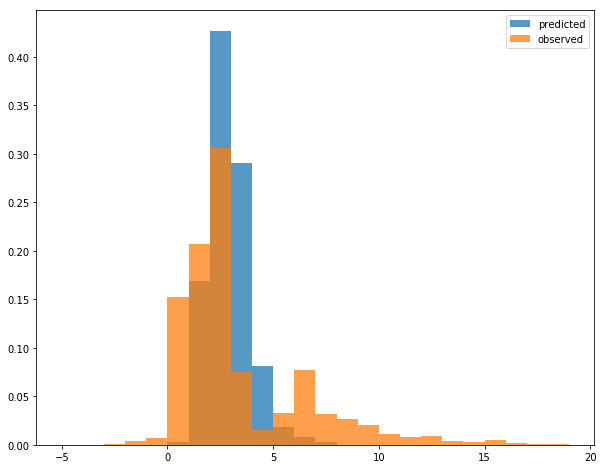

In [87]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

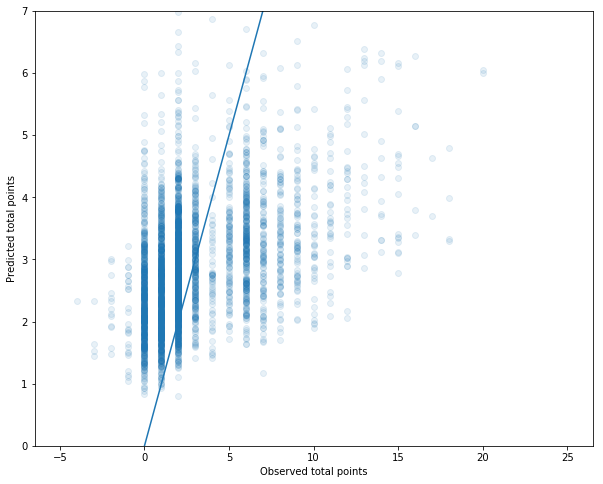

In [88]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lush_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Gradient boosted trees (stark)

In [117]:
stark_model = GradientBoostingRegressor(n_estimators=120,
                                        max_features=0.8,
                                        min_samples_leaf=0.02,
                                        learning_rate=0.05,
                                        criterion='mse',
                                        random_state=0)
stark_model.fit(stark_X_train_sel, y_train.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.02, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [118]:
# get predictions for test set
stark_y_pred = stark_model.predict(stark_X_test_sel).flatten()

# calculate cross entropy loss for test set
stark_test_loss = (
    mean_absolute_error(y_test, stark_y_pred),
    mean_squared_error(y_test, stark_y_pred),
    r2_score(y_test, stark_y_pred)
)
stark_test_loss

(2.1540633407997034, 9.370494629222755, 0.09958148712675219)

In [119]:
pd.Series(stark_y_pred).describe()

count    948.000000
mean       2.619849
std        0.946219
min        0.581861
25%        1.956696
50%        2.428434
75%        3.181456
max        6.425883
dtype: float64

In [120]:
# refit model on all data
stark_model_full = GradientBoostingRegressor(n_estimators=120,
                                             max_features=0.8,
                                             min_samples_leaf=0.02,
                                             learning_rate=0.05,
                                             criterion='mse',
                                             random_state=0)
stark_model_full.fit(stark_X_sel, y.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.02, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [121]:
# get predictions for whole set
stark_y_pred_full = stark_model_full.predict(stark_X_sel).flatten()

# calculate cross entropy loss for test set
stark_test_loss_full = (
    mean_absolute_error(y, stark_y_pred_full),
    mean_squared_error(y, stark_y_pred_full),
    r2_score(y, stark_y_pred_full)
)
stark_test_loss_full

(2.011525215131757, 7.679217589432548, 0.19745291929327224)

In [122]:
pd.Series(stark_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         1.040723
min         0.521900
25%         2.124559
50%         2.753550
75%         3.460177
max         7.745907
dtype: float64

In [123]:
abs(pd.Series(y.ravel()) - pd.Series(stark_y_pred_full)).describe()

count    3644.000000
mean        2.011525
std         1.906300
min         0.000615
25%         0.728856
50%         1.547294
75%         2.608291
max        14.854017
dtype: float64

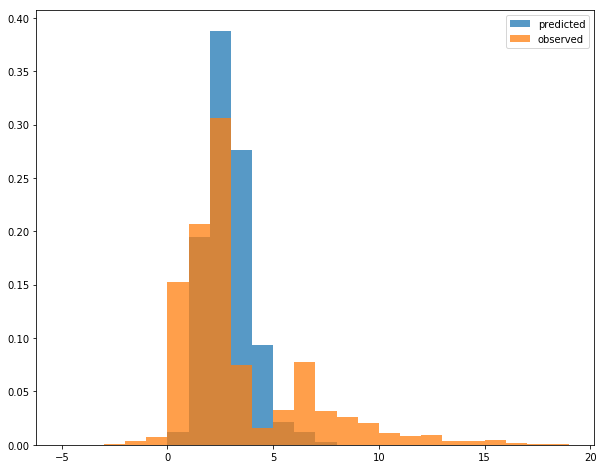

In [124]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

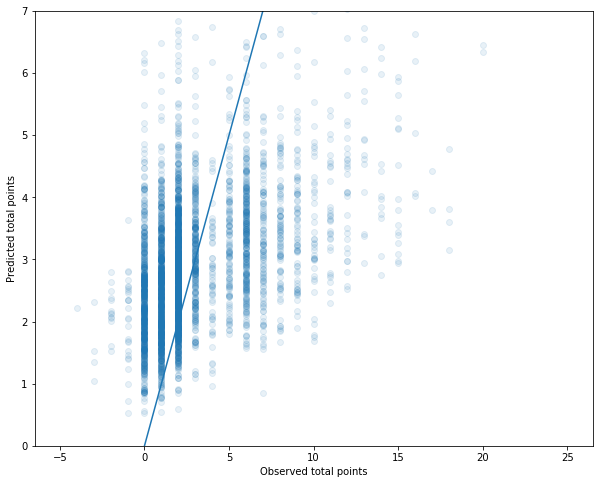

In [125]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(stark_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Summary

In [126]:
pd.DataFrame([
    ('Gradient boosted trees (lush)', lush_test_loss[0], lush_test_loss[1], lush_test_loss[2]),
    ('Gradient boosted trees (stark)', stark_test_loss[0], stark_test_loss[1], stark_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Gradient boosted trees (lush),2.178648,9.419429,0.094879
1,Gradient boosted trees (stark),2.154063,9.370495,0.099581


In [127]:
pd.DataFrame([
    ('Gradient boosted trees (lush)', lush_test_loss_full[0], lush_test_loss_full[1], lush_test_loss_full[2]),
    ('Gradient boosted trees (stark)', stark_test_loss_full[0], stark_test_loss_full[1], stark_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Gradient boosted trees (lush),2.030086,7.792888,0.185573
1,Gradient boosted trees (stark),2.011525,7.679218,0.197453
